## In class Cross-valiation and Bootstrap

### Predict the profit of startups using Regression models
Just do the cross-validation we will do the bootstrap in class

,onehotencoder__State_California,onehotencoder__State_Florida,onehotencoder__State_New York,remainder__R&D Spend,remainder__Administration,remainder__Marketing Spend,remainder__Profit
0,0.0,0.0,1.0,165349.20,136897.80,471784.10,192261.83
1,1.0,0.0,0.0,162597.70,151377.59,443898.53,191792.06
2,0.0,1.0,0.0,153441.51,101145.55,407934.54,191050.39
3,0.0,0.0,1.0,144372.41,118671.85,383199.62,182901.99
4,0.0,1.0,0.0,142107.34,91391.77,366168.42,166187.94


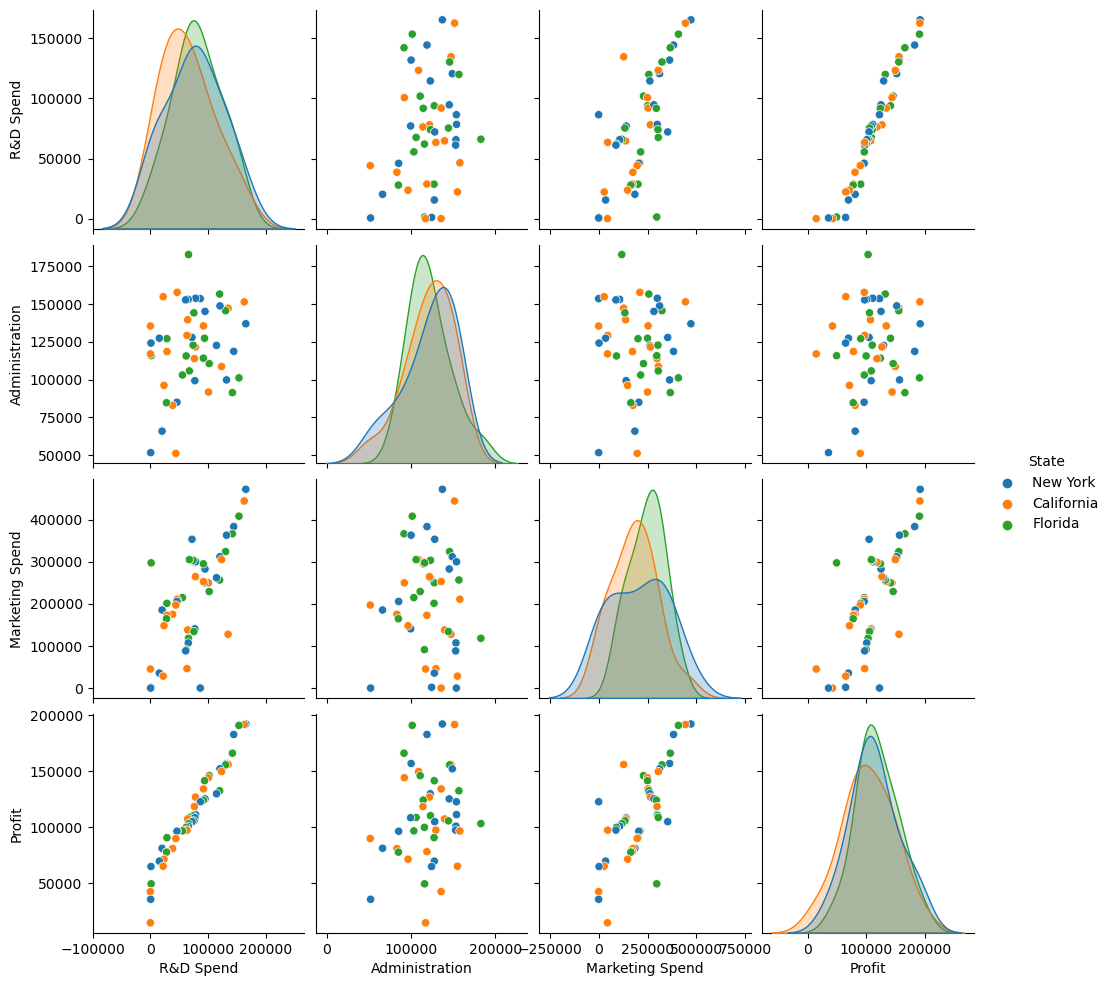

In [84]:
%matplotlib inline

from tkinter.font import names
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
import scipy.stats as st

# can just do 50:50 train and testing
df = pd.read_csv('data/50_Startups.csv')
# print(df)

transformer = make_column_transformer(
    (OneHotEncoder(), ['State']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

sns.pairplot(df,hue = 'State')

transformed_df.head()

Looking at the pair plot above it looks like Administration does not have a good correlation with Profit so I will not create a model of it. It looks like R&D spend and marketing spend have linear or non-linear relationships with profit so I will look at cross-validations using them for separate models.

### Looking at a linear regression and a polynomial Regression of Profit vs R&D spending

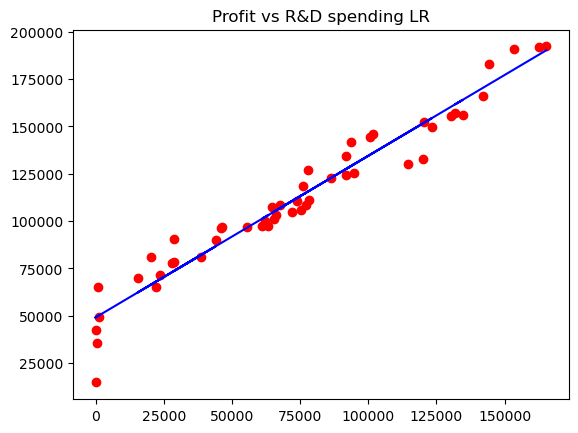

R^2 value of linear model: 0.947


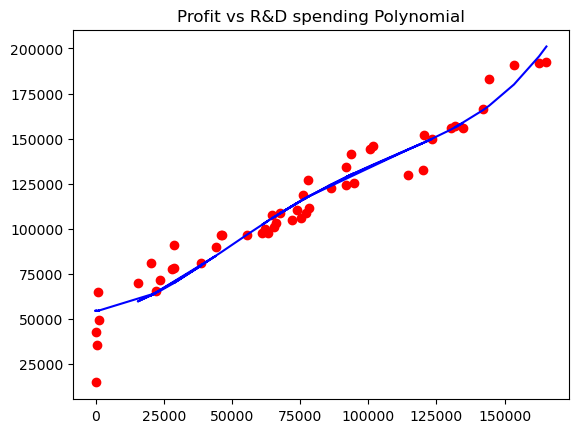

R^2 value of polynomial model: 0.934


In [85]:
X = transformed_df[['remainder__R&D Spend']]
y = transformed_df[['remainder__Profit']]

lin_reg = LinearRegression()
lin_reg.fit(X,y)
 
# visualising the linear regression model
plt.scatter(X,y, color='red')
plt.plot(X, lin_reg.predict(X),color='blue')
plt.title("Profit vs R&D spending LR")
plt.show()

print(f"R^2 value of linear model: {lin_reg.score(X,y):.3f}")
 
 
# visualising polynomial regression
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
  
plt.scatter(X,y, color='red') 
  
plt.plot(X, lin_reg2.predict(poly_reg.fit_transform(X)),color='blue') 
plt.title("Profit vs R&D spending Polynomial")
plt.show()

print(f"R^2 value of polynomial model: {lin_reg2.score(X_poly,y):.3f}")



### Cross-validation

Implementation for a k-fold cross validation function

In [91]:
def k_fold_cross_validation(data,k,num_degree):
    # create the amount of folds you want
    cv = LeaveOneOut()
    k_folds = KFold(n_splits=k,shuffle=True)
    avg_train_scores = []
    avg_test_scores = []
    avg_loocv_scores = []

    X = pd.DataFrame(data.iloc[:,0])
    y = pd.DataFrame(data.iloc[:,1])

    # go num_degree times
    for i in range(1,num_degree):
        poly = PolynomialFeatures(degree = i)
        X_poly = poly.fit_transform(X)
        train_scores = []
        test_scores = []
        loocv_scores = []
    
        # use the train to train and the validate to test
        for train_index, valid_index in k_folds.split(data):
            # print(f"Train index: {train_index}\nValid index: {valid_index}")
            lr = LinearRegression()
            lr.fit(X_poly, y)

            if k == len(data):
                scores = cross_val_score(lr, X_poly, y, scoring='neg_mean_squared_error', cv = cv, n_jobs=1)
                loocv_scores.append(np.mean(np.absolute(scores)))
                

            else:
                train_set = pd.DataFrame(y.iloc[train_index])
                valid_set = pd.DataFrame(y.iloc[valid_index])

                # gives the RSS of the data set
                train_scores.append(lr.score(X_poly[train_index],train_set))
                test_scores.append(lr.score(X_poly[valid_index], valid_set))
            
        avg_train_scores.append(sum(test_scores)/k)
        avg_test_scores.append(sum(train_scores)/k)

        avg_loocv_scores.append(sum(loocv_scores)/k)
    
    if k == len(data):
        return avg_loocv_scores
    else:
        return avg_train_scores, avg_test_scores



## Testing the implementation

R&D Spending cross-validation
Training R^2 values: 
Validating R^2 value: [0.9461262468859072, 0.9462876405191094, 0.9541427780924085, 0.9336680785494174, 0.9090982997027528, 0.8767915759087007, 0.8343442966903971, 0.7875289953408602]


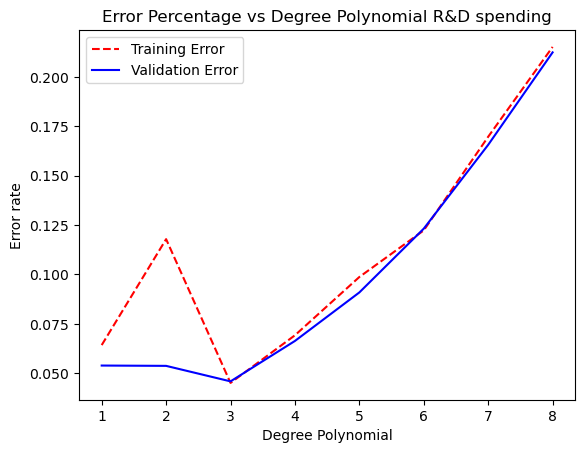

Marketing Spending cross-validation
Training R^2 values: [0.4966472643598686, 0.49381086734756713, 0.4496056302854271, 0.5395004137799823, 0.41746182537276066, 0.5637179132611104, 0.3708666946719033, 0.5394017357914562]
Validating R^2 value: [0.5554284635365702, 0.576631138600699, 0.5746912147143814, 0.5762351433803712, 0.5573146818865518, 0.5517361966251125, 0.5344832516054321, 0.5310146470507429]


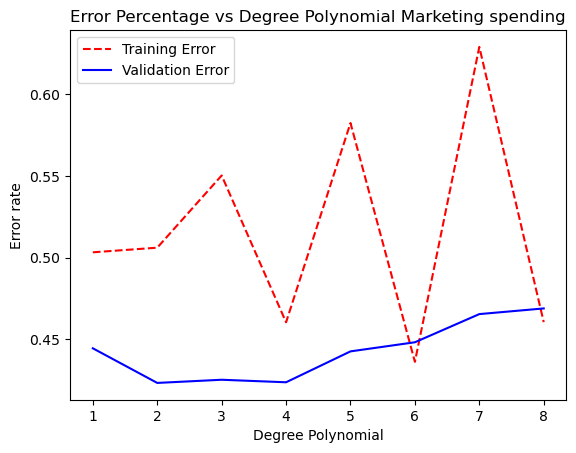

In [92]:
# R&D spending polynomial regression
X1 = transformed_df[['remainder__R&D Spend']]
y1 = transformed_df[['remainder__Profit']]
RD_df = pd.concat([X1,y1], axis=1)

train_scores1, test_scores1 = k_fold_cross_validation(RD_df,5,9)
print(f'R&D Spending cross-validation\nTraining R^2 values: ')
print(f'Validating R^2 value: {test_scores1}')

x = np.arange(1,9,1)
train_err1 = 1 - np.array(train_scores1)
test_err1 = 1 - np.array(test_scores1)

plt.plot(x, train_err1, 'r--',label='Training Error')
plt.plot(x, test_err1, 'b-',label='Validation Error')
plt.title('Error Percentage vs Degree Polynomial R&D spending')
plt.xlabel('Degree Polynomial')
plt.ylabel('Error rate')
plt.legend()
plt.show()

# Marketing polynomial Regression
X2 = transformed_df[['remainder__Marketing Spend']]
y2 = transformed_df[['remainder__Profit']]
marketing_df = pd.concat([X2,y2], axis=1)
# print(df)

train_scores2, test_scores2 = k_fold_cross_validation(marketing_df,5, 9)
print(f'Marketing Spending cross-validation\nTraining R^2 values: {train_scores2}')
print(f'Validating R^2 value: {test_scores2}')

train_err2 = 1 - np.array(train_scores2)
test_err2 = 1 - np.array(test_scores2)

plt.plot(x, train_err2, 'r--',label='Training Error')
plt.plot(x, test_err2, 'b-',label='Validation Error')
plt.title('Error Percentage vs Degree Polynomial Marketing spending')
plt.xlabel('Degree Polynomial')
plt.ylabel('Error rate')
plt.legend()
plt.show()



### K-fold cross-validation conclusion
The graphs above show that the best degree for R&D spending is probably 1 because there is only marginal improvement after the 1st degree. And the best degree for Marketing Spending is 3 because the validation error continues to go down

by atleast 2 points until the third degree polynomial. 

## Leave-one-out cross-validation (LOOCV)
Because it takes so long to run I will only do LOOCV on R&D spending

In [93]:

# R&D spending polynomial regression
test_scores3 = k_fold_cross_validation(RD_df,len(RD_df),9)
print(f'R&D Spending Leave-one-out cross-validation\nMean Square Error values: {test_scores3}')

R&D Spending cross-validation
Training R^2 values: [94814428.6337208, 101296492.907767, 92763251.39777079, 129545199.22323419, 177067988.2575304, 241616510.25321704, 326910452.9150348, 416803444.8974625]


### Plotting the MSE


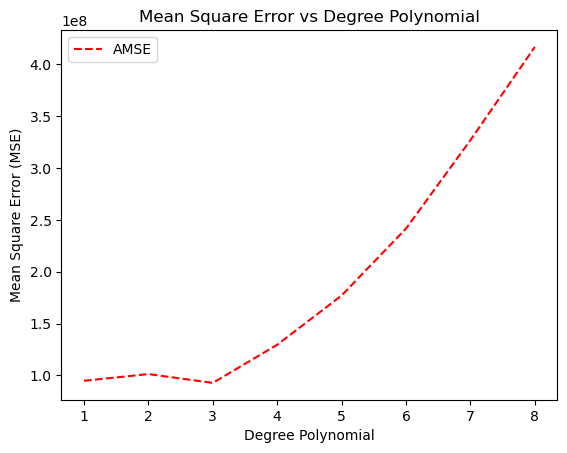

LOOCV MSE scores: 
[94814428.6337208, 101296492.907767, 92763251.39777079, 129545199.22323419, 177067988.2575304, 241616510.25321704, 326910452.9150348, 416803444.8974625]


In [99]:
plt.plot(x, test_scores3, 'r--',label='AMSE')
plt.title('Mean Square Error vs Degree Polynomial')
plt.xlabel('Degree Polynomial')
plt.ylabel('Mean Square Error (MSE)')
plt.legend()
plt.show()

print(f'LOOCV MSE scores: \n{test_scores3}')

### LOOCV conclusions

Looking at the graph above it again shows that a first degree polynomial is the best degree without overfitting. The scale is difficult to tell here because it is in the tens of millions MSE, but it does look like it goes down by two percent from first degree to third degree. But since the gain is only 2% it should just be better to keep it with a single degree because the simpler model is only marginally worse than the more complex model.